In [1]:
# 1. Install and Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import warnings
from tqdm import tqdm

# Darts
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import rmse, wmape
from darts.models import (
    ExponentialSmoothing,
    AutoARIMA,
    Prophet,
    TiDEModel,
    NBEATSModel,
    TFTModel
)

# Suppress warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger("darts").setLevel(logging.WARNING)

print("Libraries imported.")
print("Metrics: rmse (primary), wmape (secondary - handles zeros)")

Libraries imported.
Metrics: rmse (primary), wmape (secondary - handles zeros)


In [2]:
# Check availability of specific models
try:
    from darts.models import AutoARIMA
    print("AutoARIMA available.")
except ImportError:
    print("AutoARIMA NOT available.")

try:
    from darts.models import Prophet
    print("Prophet available.")
except ImportError:
    print("Prophet NOT available (install 'prophet' or 'fbprophet').")


AutoARIMA available.
Prophet available.


Loaded 9565 rows
Unique series: ['HOBBIES_1_242' 'HOBBIES_2_071' 'HOBBIES_2_108' 'HOBBIES_2_109'
 'HOBBIES_2_123']
Number of series: 5
Zeros in target: 7624 (79.7%) - using WMAPE instead of MAPE

Created 5 TimeSeries objects
Each series length: 1913 time steps

=== Scaling (fit on TRAIN only - no data leakage) ===
Future covariates scaled (fit on train): ['wday', 'month']
Past covariates scaled (fit on train): ['snap_CA', 'snap_TX', 'snap_WI']
Static covariates encoded: ['unique_id', 'unique_id_encoded']

=== Dataset Summary ===
Dataset: M5 Walmart Hobbies Daily (5 Series - Global vs Local)
Number of series: 5
Train period: 2011-01-29 00:00:00 to 2016-03-27 00:00:00 (1885 points)
Test period: 2016-03-28 00:00:00 to 2016-04-24 00:00:00 (28 points)

Features:
  Future covariates (calendar): ['wday', 'month']
  Past covariates (historical): ['snap_CA', 'snap_TX', 'snap_WI']
  Static covariates (embeddings): ['unique_id']

Data Leakage Prevention:
  ✓ Train/Test split BEFORE scaling
  ✓ Sc

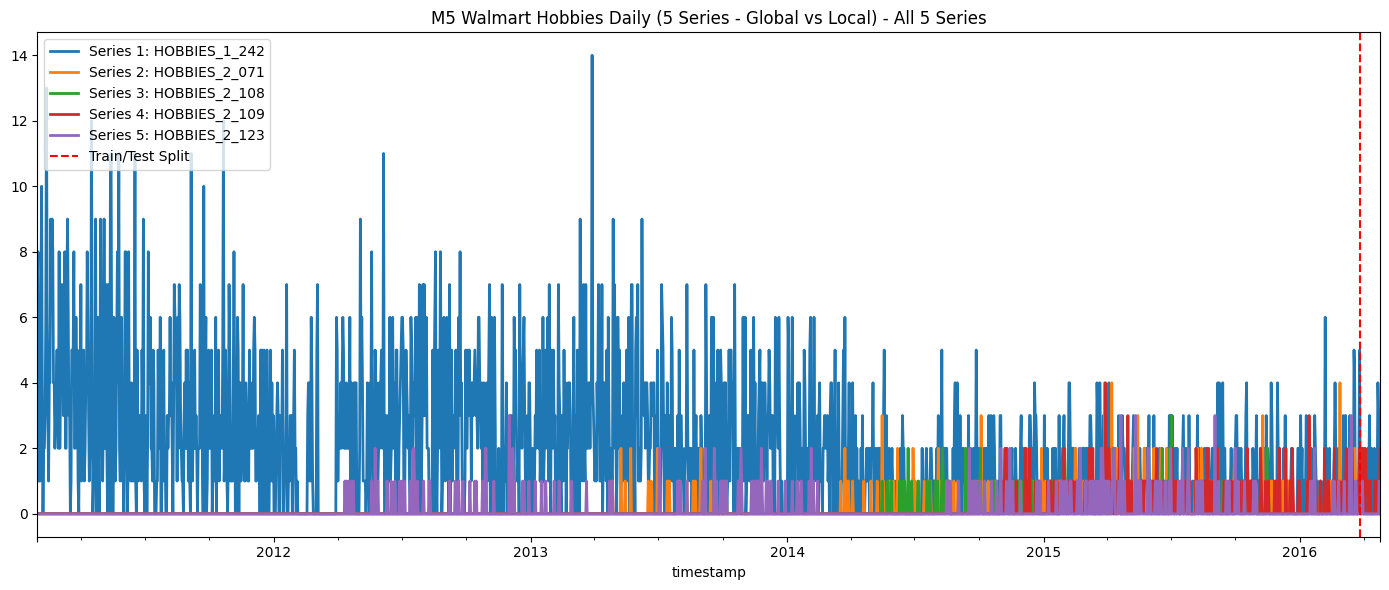

In [3]:
# 2. Load and Preprocess Data (Multi-Series: Local vs Global Forecasting)
# ============================================================================
# DATA PIPELINE FOR SALES FORECASTING:
# 1. Load multi-series data (5 product time series)
# 2. Create TimeSeries objects with static covariates (for embeddings)
# 3. Split train/test BEFORE any scaling (prevent data leakage)
# 4. Scale ONLY on training data, then transform test with train's scaler
# ============================================================================

from darts.dataprocessing.transformers import StaticCovariatesTransformer
from sklearn.preprocessing import LabelEncoder

# ============================================================================
# DATASET CONFIGURATION
# ============================================================================
DATASET_CONFIG = {
    'file_path': '../datasets/m5_walmart_hobbies_daily.csv',
    'time_column': 'timestamp',
    'target_column': 'sales_count',
    'id_column': 'unique_id',
    
    # Covariates
    'future_covariates': ['wday', 'month'],  # Known in advance (calendar features)
    'past_covariates': ['snap_CA', 'snap_TX', 'snap_WI'],  # Only known historically
    'static_covariates': ['unique_id'],  # Static per series (for DL embeddings)
    
    # Time series parameters
    'frequency': 'D',
    'test_periods': 28,
    'seasonal_period': 7,
    
    'name': 'M5 Walmart Hobbies Daily (5 Series - Global vs Local)'
}

# ============================================================================
# LOAD DATA
# ============================================================================
df = pd.read_csv(DATASET_CONFIG['file_path'])
df[DATASET_CONFIG['time_column']] = pd.to_datetime(df[DATASET_CONFIG['time_column']])

print(f"Loaded {len(df)} rows")
print(f"Unique series: {df[DATASET_CONFIG['id_column']].unique()}")
print(f"Number of series: {df[DATASET_CONFIG['id_column']].nunique()}")

# Check for zeros in target (important for WMAPE vs MAPE decision)
zero_count = (df[DATASET_CONFIG['target_column']] == 0).sum()
zero_pct = zero_count / len(df) * 100
print(f"Zeros in target: {zero_count} ({zero_pct:.1f}%) - using WMAPE instead of MAPE")

# ============================================================================
# CREATE MULTI-SERIES LIST (for Darts)
# ============================================================================

# Encode categorical static covariates for DL embeddings
static_encoder = LabelEncoder()
df['unique_id_encoded'] = static_encoder.fit_transform(df[DATASET_CONFIG['id_column']])

# Create list of TimeSeries (one per unique_id)
all_series = []
all_future_covs = []
all_past_covs = []

for uid in df[DATASET_CONFIG['id_column']].unique():
    df_uid = df[df[DATASET_CONFIG['id_column']] == uid].sort_values(DATASET_CONFIG['time_column'])
    
    # Create target series
    ts = TimeSeries.from_dataframe(
        df_uid, 
        DATASET_CONFIG['time_column'], 
        DATASET_CONFIG['target_column'],
        freq=DATASET_CONFIG['frequency']
    ).astype(np.float32)
    
    # Add static covariates (for DL embeddings)
    static_covs = pd.DataFrame({
        'unique_id': [uid],
        'unique_id_encoded': [df_uid['unique_id_encoded'].iloc[0]]
    })
    ts = ts.with_static_covariates(static_covs)
    
    all_series.append(ts)
    
    # Create future covariates
    if DATASET_CONFIG['future_covariates']:
        future_cov = TimeSeries.from_dataframe(
            df_uid,
            DATASET_CONFIG['time_column'],
            DATASET_CONFIG['future_covariates'],
            freq=DATASET_CONFIG['frequency']
        ).astype(np.float32)
        all_future_covs.append(future_cov)
    
    # Create past covariates
    if DATASET_CONFIG['past_covariates']:
        past_cov = TimeSeries.from_dataframe(
            df_uid,
            DATASET_CONFIG['time_column'],
            DATASET_CONFIG['past_covariates'],
            freq=DATASET_CONFIG['frequency']
        ).astype(np.float32)
        all_past_covs.append(past_cov)

print(f"\nCreated {len(all_series)} TimeSeries objects")
print(f"Each series length: {len(all_series[0])} time steps")

# ============================================================================
# TRAIN/TEST SPLIT (BEFORE scaling - critical for no data leakage)
# ============================================================================
freq = DATASET_CONFIG['frequency']
test_periods = DATASET_CONFIG['test_periods']

if freq == 'D':
    offset = pd.DateOffset(days=test_periods)
elif freq == 'H':
    offset = pd.DateOffset(hours=test_periods)
else:
    offset = pd.DateOffset(days=test_periods)

split_time = pd.Timestamp(all_series[0].end_time()) - offset

# Split target series
train_series = [s.split_after(split_time)[0] for s in all_series]
test_series = [s.split_after(split_time)[1] for s in all_series]

# Split covariates
if all_future_covs:
    train_future_covs = [c.split_after(split_time)[0] for c in all_future_covs]
    # For future covariates, we need the FULL series for prediction
    # (we know future values like day of week, month)
else:
    train_future_covs = None
    all_future_covs = None

if all_past_covs:
    train_past_covs = [c.split_after(split_time)[0] for c in all_past_covs]
else:
    train_past_covs = None
    all_past_covs = None

# ============================================================================
# SCALING (fit ONLY on TRAIN data - prevent data leakage)
# ============================================================================
from darts.dataprocessing.transformers import Scaler

print("\n=== Scaling (fit on TRAIN only - no data leakage) ===")

# Scale target series
# NOTE: Darts Scaler with default settings fits per-series (each series has its own mean/std)
target_scaler = Scaler()
train_scaled = target_scaler.fit_transform(train_series)  # Fit on TRAIN only
# We DON'T scale test_series - we'll inverse transform predictions instead

# Scale future covariates (fit on train portion only)
if train_future_covs:
    future_cov_scaler = Scaler()
    train_future_covs_scaled = future_cov_scaler.fit_transform(train_future_covs)  # Fit on TRAIN
    # Transform ALL future covariates using train's scaler (for prediction)
    all_future_covs_scaled = future_cov_scaler.transform(all_future_covs)
    print(f"Future covariates scaled (fit on train): {DATASET_CONFIG['future_covariates']}")
else:
    train_future_covs_scaled, all_future_covs_scaled = None, None

# Scale past covariates (fit on train portion only)
if train_past_covs:
    past_cov_scaler = Scaler()
    train_past_covs_scaled = past_cov_scaler.fit_transform(train_past_covs)  # Fit on TRAIN
    all_past_covs_scaled = past_cov_scaler.transform(all_past_covs)
    print(f"Past covariates scaled (fit on train): {DATASET_CONFIG['past_covariates']}")
else:
    train_past_covs_scaled, all_past_covs_scaled = None, None

# ============================================================================
# STATIC COVARIATES TRANSFORMER (encode categorical for DL embeddings)
# ============================================================================
static_cov_transformer = StaticCovariatesTransformer()
train_scaled = static_cov_transformer.fit_transform(train_scaled)
# NOTE: Static covariates are the same for train/test (they're static per series)

print(f"Static covariates encoded: {list(train_scaled[0].static_covariates.columns)}")

# ============================================================================
# SUMMARY
# ============================================================================
print(f"\n{'='*60}")
print(f"=== Dataset Summary ===")
print(f"{'='*60}")
print(f"Dataset: {DATASET_CONFIG['name']}")
print(f"Number of series: {len(all_series)}")
print(f"Train period: {train_series[0].start_time()} to {train_series[0].end_time()} ({len(train_series[0])} points)")
print(f"Test period: {test_series[0].start_time()} to {test_series[0].end_time()} ({len(test_series[0])} points)")
print(f"\nFeatures:")
print(f"  Future covariates (calendar): {DATASET_CONFIG['future_covariates']}")
print(f"  Past covariates (historical): {DATASET_CONFIG['past_covariates']}")
print(f"  Static covariates (embeddings): {DATASET_CONFIG['static_covariates']}")
print(f"\nData Leakage Prevention:")
print(f"  ✓ Train/Test split BEFORE scaling")
print(f"  ✓ Scalers fit ONLY on training data")
print(f"  ✓ Test data transformed with train's scaler parameters")

# Plot all series
fig, ax = plt.subplots(figsize=(14, 6))
for i, s in enumerate(all_series):
    s.plot(ax=ax, label=f'Series {i+1}: {s.static_covariates["unique_id"].values[0]}')
ax.axvline(x=split_time, color='red', linestyle='--', label='Train/Test Split')
ax.set_title(f'{DATASET_CONFIG["name"]} - All {len(all_series)} Series')
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [4]:
# 3. Define Evaluation Metrics and Logging
# ============================================================================
# METRICS FOR SALES DATA (with zeros):
# - RMSE: Primary metric, works with zeros
# - WMAPE: Built-in Darts metric - Weighted Mean Absolute Percentage Error
#   WMAPE = sum(|actual - pred|) / sum(|actual|) - handles zeros gracefully
# - MAPE is NOT suitable for sales data with zeros (division by zero)
# ============================================================================

from darts.metrics import rmse, wmape

results = []

def log_result(model_name, rmse_val, wmape_val, tuning_time, best_config_time, params=None, n_combinations=1):
    """
    Log model results with comprehensive timing information.
    
    Args:
        rmse_val: Root Mean Square Error (primary metric)
        wmape_val: Weighted Mean Absolute Percentage Error (secondary metric, handles zeros)
        tuning_time: Total time for hyperparameter tuning (all combinations + CV)
        best_config_time: Time for the best configuration only (training + CV)
        n_combinations: Number of parameter combinations evaluated
    """
    results.append({
        'Model': model_name,
        'RMSE': rmse_val,
        'WMAPE (%)': wmape_val * 100,  # Darts wmape returns 0-1, convert to %
        'Tuning Time (s)': tuning_time,
        'Best Config Time (s)': best_config_time,
        'Combinations': n_combinations,
        'Params': params
    })
    print(f"Logged: {model_name} | RMSE: {rmse_val:.4f} | WMAPE: {wmape_val*100:.2f}% | "
          f"Tuning: {tuning_time:.2f}s ({n_combinations} combos) | Best config: {best_config_time:.2f}s")

def get_results_df():
    return pd.DataFrame(results).sort_values(by='RMSE')

print("Metrics defined: RMSE (primary), WMAPE (secondary - Darts built-in)")
print("Note: MAPE is NOT used because sales data contains zeros")

Metrics defined: RMSE (primary), WMAPE (secondary - Darts built-in)
Note: MAPE is NOT used because sales data contains zeros


In [5]:
# 4. Define Hyperparameter Tuning Strategy (Grid/Random Search) & Cross Validation
# ============================================================================
# LOCAL vs GLOBAL FORECASTING:
# - LOCAL: Train separate model per series (classical statistical models)
#   * Holt-Winters (ExponentialSmoothing): NO covariates support
#   * AutoARIMA: SUPPORTS future_covariates (SARIMAX with exogenous vars)
#   * Prophet: SUPPORTS future_covariates (regressors, holidays)
# - GLOBAL: Train single model on ALL series (DL models, Foundation models)
#   * TiDE, TFT: Support future_covariates, past_covariates, static_covariates
#   * N-BEATS: NO covariate support
# ============================================================================

# SET GLOBAL SEED FOR REPRODUCIBILITY
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

def grid_search_all(param_grid):
    """Generates ALL combinations from the parameter grid (full grid search)."""
    from itertools import product
    
    if not param_grid:
        return [{}]
    
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    
    combinations = []
    for combo in product(*values):
        params = dict(zip(keys, combo))
        combinations.append(params)
    
    return combinations

def random_grid_search(param_grid, n_iter=5, seed=RANDOM_SEED):
    """Generates random parameter combinations from the grid."""
    rng = random.Random(seed)
    keys = list(param_grid.keys())
    
    if not keys:
        return [{}]

    combinations = []
    for _ in range(n_iter):
        params = {key: rng.choice(param_grid[key]) for key in keys}
        combinations.append(params)
    
    # Remove duplicates
    seen = set()
    unique_combinations = []
    for d in combinations:
        key = frozenset((k, str(v)) for k, v in d.items())
        if key not in seen:
            seen.add(key)
            unique_combinations.append(d)
    
    return unique_combinations

# ============================================================================
# LOCAL FORECASTING EVALUATION (train per series)
# NOTE: LOCAL models work on UNSCALED data (original scale)
# Covariate support varies by model:
#   - Holt-Winters: NO covariates
#   - AutoARIMA: future_covariates (SARIMAX)
#   - Prophet: future_covariates (regressors)
# ============================================================================
def evaluate_local_model(model_cls, params, train_list, 
                         future_covs_list=None, supports_covariates=False,
                         forecast_horizon=12, stride=1):
    """
    Evaluate LOCAL model: train separately on each series, aggregate metrics.
    
    Args:
        model_cls: Model class (ExponentialSmoothing, AutoARIMA, Prophet)
        params: Model hyperparameters
        train_list: List of training TimeSeries (unscaled)
        future_covs_list: List of future covariates (only for models that support them)
        supports_covariates: Whether this model supports future_covariates
    """
    start_time = time.time()
    
    all_backtest = []
    all_actual = []
    
    try:
        for i, train_s in enumerate(train_list):
            model = model_cls(**params)
            
            # Get covariates for this series if supported
            future_cov = future_covs_list[i] if (supports_covariates and future_covs_list) else None
            
            # Historical forecasts with retraining
            backtest = model.historical_forecasts(
                series=train_s,
                future_covariates=future_cov,
                start=0.7,
                forecast_horizon=forecast_horizon,
                stride=stride,
                retrain=True,
                verbose=False,
                last_points_only=True
            )
            
            all_backtest.append(backtest)
            all_actual.append(train_s)
        
        # Calculate aggregate metrics across all series
        # RMSE: average of per-series RMSE
        avg_rmse = np.mean([rmse(a, b) for a, b in zip(all_actual, all_backtest)])
        # WMAPE: use Darts built-in (handles list of series)
        avg_wmape = wmape(all_actual, all_backtest)
        
        duration = time.time() - start_time
        return avg_rmse, avg_wmape, duration
        
    except Exception as e:
        print(f"Error in LOCAL model {model_cls.__name__}: {e}")
        import traceback
        traceback.print_exc()
        return float('inf'), float('inf'), 0

# ============================================================================
# GLOBAL FORECASTING EVALUATION (train on all series at once)
# NOTE: GLOBAL models work on SCALED data and CAN use covariates
# ============================================================================
def evaluate_global_model(model_cls, params, train_scaled_list, 
                          original_train_list, target_scaler, forecast_horizon=12, stride=1,
                          future_covs=None, past_covs=None):
    """
    Evaluate GLOBAL model: train ONCE on all series, aggregate metrics.
    Used for: TiDE, N-BEATS, TFT (DL models), Foundation models
    
    NOTE: 
    - Input is SCALED data (required for DL models)
    - Output is inverse-transformed back to original scale for metrics
    - Covariates ARE used (where supported)
    """
    start_time = time.time()
    
    try:
        model = model_cls(**params)
        
        # GLOBAL FIT: Train on ALL series at once (with covariates)
        model.fit(
            series=train_scaled_list,
            future_covariates=future_covs,
            past_covariates=past_covs,
            verbose=False
        )
        
        all_backtest = []
        all_actual = []
        
        # Evaluate on each series
        for i, (train_s, orig_train) in enumerate(zip(train_scaled_list, original_train_list)):
            # Historical forecasts (no retraining for global model)
            backtest_scaled = model.historical_forecasts(
                series=train_s,
                future_covariates=future_covs[i] if future_covs else None,
                past_covariates=past_covs[i] if past_covs else None,
                start=0.7,
                forecast_horizon=forecast_horizon,
                stride=stride,
                retrain=False,  # No retraining for global model
                verbose=False,
                last_points_only=True
            )
            
            # Inverse transform back to original scale
            backtest = target_scaler.inverse_transform(backtest_scaled)
            
            all_backtest.append(backtest)
            all_actual.append(orig_train)
        
        # Calculate aggregate metrics
        avg_rmse = np.mean([rmse(a, b) for a, b in zip(all_actual, all_backtest)])
        avg_wmape = wmape(all_actual, all_backtest)
        
        duration = time.time() - start_time
        return avg_rmse, avg_wmape, duration
        
    except Exception as e:
        print(f"Error in GLOBAL model {model_cls.__name__}: {e}")
        import traceback
        traceback.print_exc()
        return float('inf'), float('inf'), 0

# ============================================================================
# UNIFIED TUNING FUNCTIONS
# ============================================================================
def run_tuning_local(model_name, model_cls, param_grid, train_list, 
                     future_covs_list=None, supports_covariates=False,
                     use_full_grid=True, n_iter=5):
    """
    Run hyperparameter tuning for LOCAL models.
    
    Args:
        future_covs_list: Future covariates for each series
        supports_covariates: Whether this model supports future_covariates
    """
    cov_note = "WITH future_covariates" if supports_covariates else "NO covariates"
    print(f"--- Tuning {model_name} (LOCAL: {len(train_list)} series, {cov_note}) ---")
    
    tuning_start = time.time()
    
    if use_full_grid:
        combinations = grid_search_all(param_grid)
        print(f"Full grid search: {len(combinations)} combinations")
    else:
        combinations = random_grid_search(param_grid, n_iter=n_iter)
        print(f"Random search: {len(combinations)} combinations")
    
    best_rmse = float('inf')
    best_params = None
    best_wmape = float('inf')
    best_config_time = 0
    
    for params in tqdm(combinations, desc=f"Tuning {model_name}"):
        rmse_val, wmape_val, config_time = evaluate_local_model(
            model_cls, params, train_list,
            future_covs_list=future_covs_list,
            supports_covariates=supports_covariates
        )
        
        if rmse_val < best_rmse:
            best_rmse = rmse_val
            best_params = params
            best_wmape = wmape_val
            best_config_time = config_time
    
    tuning_total = time.time() - tuning_start
    
    if best_params and best_rmse != float('inf'):
        log_result(model_name, best_rmse, best_wmape, tuning_total, best_config_time, 
                   best_params, n_combinations=len(combinations))
    else:
        print(f"No successful run for {model_name}")
    
    return best_params

def run_tuning_global(model_name, model_cls, param_grid, 
                      train_scaled_list, original_train_list, target_scaler,
                      future_covs=None, past_covs=None, use_full_grid=False, n_iter=10):
    """
    Run hyperparameter tuning for GLOBAL models.
    """
    cov_note = []
    if future_covs: cov_note.append("future")
    if past_covs: cov_note.append("past")
    cov_str = f"WITH {'+'.join(cov_note)} covariates" if cov_note else "NO covariates"
    
    print(f"--- Tuning {model_name} (GLOBAL: {len(train_scaled_list)} series, {cov_str}) ---")
    
    tuning_start = time.time()
    
    if use_full_grid:
        combinations = grid_search_all(param_grid)
        print(f"Full grid search: {len(combinations)} combinations")
    else:
        combinations = random_grid_search(param_grid, n_iter=n_iter)
        print(f"Random search: {len(combinations)} combinations")
    
    best_rmse = float('inf')
    best_params = None
    best_wmape = float('inf')
    best_config_time = 0
    
    for params in tqdm(combinations, desc=f"Tuning {model_name}"):
        rmse_val, wmape_val, config_time = evaluate_global_model(
            model_cls, params, train_scaled_list,
            original_train_list, target_scaler,
            future_covs=future_covs, past_covs=past_covs
        )
        
        if rmse_val < best_rmse:
            best_rmse = rmse_val
            best_params = params
            best_wmape = wmape_val
            best_config_time = config_time
    
    tuning_total = time.time() - tuning_start
    
    if best_params and best_rmse != float('inf'):
        log_result(model_name, best_rmse, best_wmape, tuning_total, best_config_time,
                   best_params, n_combinations=len(combinations))
    else:
        print(f"No successful run for {model_name}")
    
    return best_params

print(f"Random seed: {RANDOM_SEED}")
print(f"\nForecasting modes:")
print(f"  LOCAL models:")
print(f"    - Holt-Winters: NO covariates")
print(f"    - AutoARIMA: SUPPORTS future_covariates (SARIMAX)")
print(f"    - Prophet: SUPPORTS future_covariates (regressors)")
print(f"  GLOBAL models:")
print(f"    - TiDE, TFT: SUPPORT all covariates")
print(f"    - N-BEATS: NO covariates")

Random seed: 42

Forecasting modes:
  LOCAL models:
    - Holt-Winters: NO covariates
    - AutoARIMA: SUPPORTS future_covariates (SARIMAX)
    - Prophet: SUPPORTS future_covariates (regressors)
  GLOBAL models:
    - TiDE, TFT: SUPPORT all covariates
    - N-BEATS: NO covariates


In [ ]:
# 5. Train and Evaluate Statistical Models (LOCAL Forecasting)
# ============================================================================
# LOCAL FORECASTING: Each model is trained separately on each time series
# 
# COVARIATE SUPPORT:
# - Holt-Winters (ExponentialSmoothing): NO covariates
# - AutoARIMA: SUPPORTS future_covariates (SARIMAX with exogenous variables)
# - Prophet: SUPPORTS future_covariates (regressors, add_regressors)
# ============================================================================
from darts.utils.utils import ModelMode

SEASONAL_PERIOD = DATASET_CONFIG['seasonal_period']
print(f"=== LOCAL FORECASTING (Statistical Models) ===")
print(f"Training {len(train_series)} models per hyperparameter combination")
print(f"Seasonal period: {SEASONAL_PERIOD}")

# ============================================================================
# Holt-Winters (ExponentialSmoothing) - NO covariates
# ============================================================================
print(f"\n--- Holt-Winters: NO covariate support ---")
hw_grid = {
    'seasonal_periods': [SEASONAL_PERIOD],
    'trend': [ModelMode.ADDITIVE, ModelMode.NONE],  # Removed MULTIPLICATIVE (fails with zeros)
    'seasonal': [ModelMode.ADDITIVE, ModelMode.NONE],  # Removed MULTIPLICATIVE (fails with zeros)
    'damped': [True, False]
}
run_tuning_local("Holt-Winters (LOCAL)", ExponentialSmoothing, hw_grid, 
                 train_series, 
                 future_covs_list=None,  # No covariates for Holt-Winters
                 supports_covariates=False,
                 use_full_grid=True)

# ============================================================================
# AutoARIMA - SUPPORTS future_covariates (SARIMAX)
# ============================================================================
try:
    AutoARIMA()
    arima_available = True
except:
    print("AutoARIMA not available. Skipping.")
    arima_available = False

if arima_available:
    print(f"\n--- AutoARIMA: WITH future_covariates (SARIMAX) ---")
    arima_grid = {
        'season_length': [SEASONAL_PERIOD],
        'seasonal': [True] if SEASONAL_PERIOD > 1 else [False],
        'max_p': [5],
        'max_q': [5],
        'max_P': [2],
        'max_Q': [2],
        'max_D': [1],
    }
    run_tuning_local("AutoARIMA (LOCAL)", AutoARIMA, arima_grid, 
                     train_series,
                     future_covs_list=all_future_covs,  # AutoARIMA supports future covariates
                     supports_covariates=True,
                     use_full_grid=True)

# ============================================================================
# Prophet - SUPPORTS future_covariates (regressors)
# ============================================================================
try:
    Prophet()
    prophet_available = True
except:
    print("Prophet not available. Skipping.")
    prophet_available = False

if prophet_available:
    print(f"\n--- Prophet: WITH future_covariates (regressors) ---")
    prophet_grid = {
        'seasonality_mode': ['additive'],  # Only additive (multiplicative can fail with zeros)
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5]
    }
    run_tuning_local("Prophet (LOCAL)", Prophet, prophet_grid, 
                     train_series,
                     future_covs_list=all_future_covs,  # Prophet supports future covariates
                     supports_covariates=True,
                     use_full_grid=True)

print("\n=== LOCAL models completed ===")
print("Summary:")
print("  - Holt-Winters: Trained without covariates")
print("  - AutoARIMA: Trained WITH future_covariates (wday, month)")
print("  - Prophet: Trained WITH future_covariates (wday, month)")

=== LOCAL FORECASTING (Statistical Models) ===
Training 5 models per hyperparameter combination
Seasonal period: 7

--- Holt-Winters: NO covariate support ---
--- Tuning Holt-Winters (LOCAL) (LOCAL: 5 series, NO covariates) ---
Full grid search: 8 combinations


Tuning Holt-Winters (LOCAL):   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
# 6. Train and Evaluate Deep Learning Models (GLOBAL Forecasting)
# ============================================================================
# GLOBAL FORECASTING: Single model trained on ALL series at once
# This leverages cross-series patterns and is much faster for many series
# 
# KEY DIFFERENCES from LOCAL:
# - Trains 1 model on ALL series (not N models for N series)
# - Uses SCALED data (required for neural networks)
# - Uses COVARIATES (future_covs, past_covs) where supported
# - Uses STATIC COVARIATES for series embeddings (unique_id encoded)
# ============================================================================

print(f"=== GLOBAL FORECASTING (Deep Learning Models) ===")
print(f"Training 1 model on {len(train_scaled)} series simultaneously")
print(f"Using: scaled data + covariates + static embeddings")

# Adaptive input/output chunk lengths based on seasonality
base_chunk = SEASONAL_PERIOD
common_dl_params = {
    'input_chunk_length': [base_chunk, base_chunk * 2],
    'output_chunk_length': [1, base_chunk // 2 if base_chunk > 2 else 1, base_chunk],
    'n_epochs': [10, 20],
    'random_state': [RANDOM_SEED],
    'use_static_covariates': [True]  # Use encoded unique_id for embeddings
}

print(f"Input chunk options: {common_dl_params['input_chunk_length']}")
print(f"Output chunk options: {common_dl_params['output_chunk_length']}")

# TiDE (Time-series Dense Encoder) - supports all covariate types
tide_grid = {
    **common_dl_params,
    'hidden_size': [64, 128],
    'dropout': [0.1, 0.2],
    'num_encoder_layers': [1, 2],
    'num_decoder_layers': [1, 2]
}
run_tuning_global("TiDE (GLOBAL)", TiDEModel, tide_grid,
                  train_scaled, train_series, target_scaler,
                  future_covs=train_future_covs_scaled,
                  past_covs=train_past_covs_scaled,
                  use_full_grid=False, n_iter=10)

# N-BEATS (Neural Basis Expansion Analysis) - does NOT support covariates
nbeats_grid = {
    'input_chunk_length': [base_chunk, base_chunk * 2],
    'output_chunk_length': [1, base_chunk // 2 if base_chunk > 2 else 1, base_chunk],
    'n_epochs': [10, 20],
    'random_state': [RANDOM_SEED],
    'num_stacks': [10, 20],
    'num_blocks': [1, 2],
    'layer_widths': [128, 256]
}
print("\nNote: N-BEATS does NOT support covariates (similar limitation to LOCAL models)")
run_tuning_global("N-BEATS (GLOBAL)", NBEATSModel, nbeats_grid,
                  train_scaled, train_series, target_scaler,
                  future_covs=None,  # N-BEATS doesn't use covariates
                  past_covs=None,
                  use_full_grid=False, n_iter=10)

# TFT (Temporal Fusion Transformer) - supports all covariate types
tft_grid = {
    **common_dl_params,
    'hidden_size': [16, 32],
    'lstm_layers': [1],
    'num_attention_heads': [4],
    'dropout': [0.1],
    'add_relative_index': [True]
}
run_tuning_global("TFT (GLOBAL)", TFTModel, tft_grid,
                  train_scaled, train_series, target_scaler,
                  future_covs=train_future_covs_scaled,
                  past_covs=train_past_covs_scaled,
                  use_full_grid=False, n_iter=10)

print("\n=== GLOBAL DL models completed ===")

In [ ]:
# 7. Foundation Models (GLOBAL Forecasting - Pre-trained)
# ============================================================================
# GLOBAL FORECASTING: Pre-trained models that can handle multiple series
# Chronos, TimeGPT - zero-shot or few-shot, no training required
# 
# NOTE: These models work on UNSCALED data (they have their own normalization)
# NOTE: Metrics are calculated on TEST set (not CV like other models)
# ============================================================================

print(f"=== FOUNDATION MODELS (Pre-trained, GLOBAL) ===")
print(f"NOTE: Foundation models use the TEST set for evaluation (zero-shot prediction)")

API_KEYS = {
    'NIXTLA_API_KEY': None,  # Get from https://dashboard.nixtla.io/
}

# ============================================================================
# CHRONOS (Amazon) - Local, pre-trained transformer
# Works on UNSCALED data (has internal normalization)
# ============================================================================
chronos_available = False
try:
    from chronos import ChronosPipeline
    import torch
    chronos_available = True
    print("Chronos available (chronos-forecasting)")
except ImportError:
    print("Chronos not available. Install with: pip install chronos-forecasting")

if chronos_available:
    try:
        start_time = time.time()
        
        pipeline = ChronosPipeline.from_pretrained(
            "amazon/chronos-t5-small",
            device_map="mps" if torch.backends.mps.is_available() else "cpu",
            torch_dtype=torch.float32
        )
        
        all_pred_chronos = []
        all_actual_chronos = []
        
        # Predict for each series (Chronos uses same pretrained weights)
        for i, (train_s, test_s) in enumerate(zip(train_series, test_series)):
            # Chronos works on UNSCALED data
            context = torch.tensor(train_s.values().flatten())
            forecast = pipeline.predict(context, prediction_length=len(test_s), num_samples=20)
            pred_values = forecast.median(dim=1).values.numpy()
            
            pred_ts = TimeSeries.from_times_and_values(
                times=test_s.time_index,
                values=pred_values
            )
            
            all_pred_chronos.append(pred_ts)
            all_actual_chronos.append(test_s)
        
        chronos_time = time.time() - start_time
        
        # Calculate aggregate metrics using Darts wmape
        avg_rmse_chronos = np.mean([rmse(a, p) for a, p in zip(all_actual_chronos, all_pred_chronos)])
        avg_wmape_chronos = wmape(all_actual_chronos, all_pred_chronos)
        
        log_result("Chronos (GLOBAL)", avg_rmse_chronos, avg_wmape_chronos, 
                   chronos_time, chronos_time, {'model': 'chronos-t5-small'}, n_combinations=1)
        
    except Exception as e:
        print(f"Chronos error: {e}")
        import traceback
        traceback.print_exc()

# ============================================================================
# TIMEGPT (Nixtla) - API-based, pre-trained
# Works on UNSCALED data
# ============================================================================
timegpt_available = False
try:
    from nixtla import NixtlaClient
    timegpt_available = True
    print("TimeGPT available (nixtla)")
except ImportError:
    print("TimeGPT not available. Install with: pip install nixtla")

if timegpt_available and API_KEYS['NIXTLA_API_KEY']:
    try:
        start_time = time.time()
        
        nixtla_client = NixtlaClient(api_key=API_KEYS['NIXTLA_API_KEY'])
        
        # TimeGPT can handle multiple series - prepare combined dataframe
        combined_df = []
        for i, train_s in enumerate(train_series):
            df_s = train_s.pd_dataframe().reset_index()
            df_s.columns = ['ds', 'y']
            df_s['unique_id'] = f'series_{i}'
            combined_df.append(df_s)
        
        combined_df = pd.concat(combined_df, ignore_index=True)
        
        # Forecast all series at once (true GLOBAL)
        forecast_df = nixtla_client.forecast(
            df=combined_df,
            h=len(test_series[0]),
            model='timegpt-1',
            freq=DATASET_CONFIG['frequency']
        )
        
        all_pred_timegpt = []
        all_actual_timegpt = []
        
        # Calculate metrics per series
        for i, test_s in enumerate(test_series):
            pred_df = forecast_df[forecast_df['unique_id'] == f'series_{i}']
            pred_ts = TimeSeries.from_times_and_values(
                times=test_s.time_index,
                values=pred_df['TimeGPT'].values
            )
            all_pred_timegpt.append(pred_ts)
            all_actual_timegpt.append(test_s)
        
        timegpt_time = time.time() - start_time
        
        # Calculate aggregate metrics using Darts wmape
        avg_rmse_timegpt = np.mean([rmse(a, p) for a, p in zip(all_actual_timegpt, all_pred_timegpt)])
        avg_wmape_timegpt = wmape(all_actual_timegpt, all_pred_timegpt)
        
        log_result("TimeGPT (GLOBAL)", avg_rmse_timegpt, avg_wmape_timegpt,
                   timegpt_time, timegpt_time, {'model': 'timegpt-1'}, n_combinations=1)
        
    except Exception as e:
        print(f"TimeGPT error: {e}")
elif timegpt_available and not API_KEYS['NIXTLA_API_KEY']:
    print("TimeGPT: API key not set. Set API_KEYS['NIXTLA_API_KEY'] to use.")

print("\n=== Foundation Models Summary ===")
print(f"Chronos: {'Evaluated' if chronos_available else 'Not installed'}")
print(f"TimeGPT: {'Evaluated' if (timegpt_available and API_KEYS['NIXTLA_API_KEY']) else 'API key needed' if timegpt_available else 'Not installed'}")

In [ ]:
# 8. Compare Results: LOCAL vs GLOBAL Forecasting

results_df = get_results_df()

# Add forecasting type column
results_df['Type'] = results_df['Model'].apply(lambda x: 'GLOBAL' if 'GLOBAL' in x else 'LOCAL')

print("=== Results Summary ===")
print(results_df[['Model', 'Type', 'RMSE', 'WMAPE (%)', 'Tuning Time (s)', 'Combinations']])

# ============================================================================
# Visualization: LOCAL vs GLOBAL comparison
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Color by type
colors = ['coral' if t == 'LOCAL' else 'steelblue' for t in results_df['Type']]

# RMSE comparison (primary metric)
axes[0, 0].barh(results_df['Model'], results_df['RMSE'], color=colors)
axes[0, 0].set_xlabel('RMSE (lower is better)')
axes[0, 0].set_title('Model Comparison - RMSE (Primary Metric)')
axes[0, 0].invert_yaxis()

# WMAPE comparison (secondary metric - handles zeros)
axes[0, 1].barh(results_df['Model'], results_df['WMAPE (%)'], color=colors)
axes[0, 1].set_xlabel('WMAPE % (lower is better)')
axes[0, 1].set_title('Model Comparison - WMAPE (Handles Zeros in Sales)')
axes[0, 1].invert_yaxis()

# Tuning Time (key comparison: LOCAL should be slower with more series)
axes[1, 0].barh(results_df['Model'], results_df['Tuning Time (s)'], color=colors)
axes[1, 0].set_xlabel('Total Tuning Time (seconds)')
axes[1, 0].set_title(f'Tuning Time (LOCAL trains {len(train_series)} models, GLOBAL trains 1)')
axes[1, 0].invert_yaxis()
for i, (model, combos, time_s) in enumerate(zip(results_df['Model'], results_df['Combinations'], results_df['Tuning Time (s)'])):
    axes[1, 0].annotate(f'{time_s:.1f}s ({combos} combos)', 
                        xy=(time_s, i), xytext=(5, 0), 
                        textcoords='offset points', va='center', fontsize=8)

# Efficiency: RMSE per second of tuning time
results_df['Efficiency'] = results_df['RMSE'] / (results_df['Tuning Time (s)'] + 1)
axes[1, 1].barh(results_df['Model'], 1/results_df['Efficiency'], color=colors)
axes[1, 1].set_xlabel('Speed/Accuracy Ratio (higher is better)')
axes[1, 1].set_title('Efficiency: Accuracy per Unit Time')
axes[1, 1].invert_yaxis()

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='coral', label='LOCAL (per series, NO covariates)'),
                   Patch(facecolor='steelblue', label='GLOBAL (all series, WITH covariates)')]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.02))

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

# ============================================================================
# Summary Statistics
# ============================================================================
print("\n" + "="*70)
print("=== LOCAL vs GLOBAL Summary ===")
print("="*70)

local_results = results_df[results_df['Type'] == 'LOCAL']
global_results = results_df[results_df['Type'] == 'GLOBAL']

if not local_results.empty:
    best_local = local_results.sort_values('RMSE').iloc[0]
    print(f"\nLOCAL Models (trained {len(train_series)} models per HP combination, NO covariates):")
    print(f"  Best: {best_local['Model']}")
    print(f"  RMSE: {best_local['RMSE']:.4f} | WMAPE: {best_local['WMAPE (%)']:.2f}%")
    print(f"  Avg Tuning Time: {local_results['Tuning Time (s)'].mean():.2f}s")

if not global_results.empty:
    best_global = global_results.sort_values('RMSE').iloc[0]
    print(f"\nGLOBAL Models (trained 1 model on all series, WITH covariates):")
    print(f"  Best: {best_global['Model']}")
    print(f"  RMSE: {best_global['RMSE']:.4f} | WMAPE: {best_global['WMAPE (%)']:.2f}%")
    print(f"  Avg Tuning Time: {global_results['Tuning Time (s)'].mean():.2f}s")

# Overall comparison
print(f"\n{'='*70}")
print(f"OVERALL Best RMSE: {results_df.iloc[0]['Model']} ({results_df.iloc[0]['RMSE']:.4f})")
print(f"OVERALL Best WMAPE: {results_df.sort_values('WMAPE (%)').iloc[0]['Model']} ({results_df.sort_values('WMAPE (%)').iloc[0]['WMAPE (%)']:.2f}%)")
print(f"OVERALL Fastest: {results_df.sort_values('Tuning Time (s)').iloc[0]['Model']} ({results_df.sort_values('Tuning Time (s)').iloc[0]['Tuning Time (s)']:.2f}s)")

In [ ]:
# 9. Final Predictions: Best LOCAL vs Best GLOBAL

if not results_df.empty:
    local_results = results_df[results_df['Type'] == 'LOCAL']
    global_results = results_df[results_df['Type'] == 'GLOBAL']
    
    # Select best from each category (by RMSE)
    best_local = local_results.sort_values('RMSE').iloc[0] if not local_results.empty else None
    best_global = global_results.sort_values('RMSE').iloc[0] if not global_results.empty else None
    
    # Create prediction plots for all series
    n_series = len(train_series)
    fig, axes = plt.subplots(n_series, 2, figsize=(16, 4*n_series))
    if n_series == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_series):
        series_name = all_series[i].static_covariates['unique_id'].values[0]
        
        # === LOCAL MODEL PREDICTION ===
        if best_local is not None:
            model_name = best_local['Model'].replace(' (LOCAL)', '')
            
            # Map models to their covariate support
            model_info = {
                "Holt-Winters": {"cls": ExponentialSmoothing, "supports_covariates": False},
                "AutoARIMA": {"cls": AutoARIMA, "supports_covariates": True},
                "Prophet": {"cls": Prophet, "supports_covariates": True},
            }
            
            if model_name in model_info:
                try:
                    info = model_info[model_name]
                    model = info["cls"](**best_local['Params'])
                    
                    # Use covariates if supported
                    if info["supports_covariates"] and all_future_covs:
                        model.fit(train_series[i], future_covariates=all_future_covs[i])
                        pred = model.predict(len(test_series[i]), future_covariates=all_future_covs[i])
                        cov_note = "(With future_covariates)"
                    else:
                        model.fit(train_series[i])
                        pred = model.predict(len(test_series[i]))
                        cov_note = "(No covariates)"
                    
                    train_series[i].plot(ax=axes[i, 0], label='Train')
                    test_series[i].plot(ax=axes[i, 0], label='Actual')
                    pred.plot(ax=axes[i, 0], label=f'Pred ({model_name})')
                    axes[i, 0].set_title(f'{series_name} - LOCAL: {model_name}\n{cov_note}')
                    axes[i, 0].legend(loc='upper left')
                except Exception as e:
                    axes[i, 0].text(0.5, 0.5, f'Error: {e}', ha='center', va='center', transform=axes[i, 0].transAxes)
                    axes[i, 0].set_title(f'{series_name} - LOCAL: {model_name} (Error)')
            else:
                axes[i, 0].text(0.5, 0.5, 'No LOCAL model', ha='center', va='center', transform=axes[i, 0].transAxes)
        else:
            axes[i, 0].text(0.5, 0.5, 'No LOCAL results', ha='center', va='center', transform=axes[i, 0].transAxes)
        
        # === GLOBAL MODEL PREDICTION ===
        if best_global is not None:
            model_name = best_global['Model'].replace(' (GLOBAL)', '')
            model_map = {
                "TiDE": TiDEModel,
                "N-BEATS": NBEATSModel,
                "TFT": TFTModel,
            }
            
            if model_name in model_map:
                try:
                    # Train GLOBAL model on all series (only once, reuse for all series)
                    if i == 0:
                        global_model = model_map[model_name](**best_global['Params'])
                        global_model.fit(
                            series=train_scaled,
                            future_covariates=train_future_covs_scaled if model_name != "N-BEATS" else None,
                            past_covariates=train_past_covs_scaled if model_name != "N-BEATS" else None,
                            verbose=False
                        )
                    
                    # Predict for this series
                    pred_scaled = global_model.predict(
                        n=len(test_series[i]),
                        series=train_scaled[i],
                        future_covariates=all_future_covs_scaled[i] if model_name != "N-BEATS" else None,
                        past_covariates=all_past_covs_scaled[i] if model_name != "N-BEATS" else None
                    )
                    pred = target_scaler.inverse_transform(pred_scaled)
                    
                    train_series[i].plot(ax=axes[i, 1], label='Train')
                    test_series[i].plot(ax=axes[i, 1], label='Actual')
                    pred.plot(ax=axes[i, 1], label=f'Pred ({model_name})')
                    cov_note = "(With all covariates)" if model_name != "N-BEATS" else "(No covariates)"
                    axes[i, 1].set_title(f'{series_name} - GLOBAL: {model_name}\n{cov_note}')
                    axes[i, 1].legend(loc='upper left')
                except Exception as e:
                    axes[i, 1].text(0.5, 0.5, f'Error: {e}', ha='center', va='center', transform=axes[i, 1].transAxes)
                    import traceback
                    traceback.print_exc()
            elif model_name == "Chronos":
                try:
                    context = torch.tensor(train_series[i].values().flatten())
                    forecast = pipeline.predict(context, prediction_length=len(test_series[i]), num_samples=20)
                    pred_values = forecast.median(dim=1).values.numpy()
                    pred = TimeSeries.from_times_and_values(times=test_series[i].time_index, values=pred_values)
                    
                    train_series[i].plot(ax=axes[i, 1], label='Train')
                    test_series[i].plot(ax=axes[i, 1], label='Actual')
                    pred.plot(ax=axes[i, 1], label='Pred (Chronos)')
                    axes[i, 1].set_title(f'{series_name} - GLOBAL: Chronos\n(Pre-trained, no covariates)')
                    axes[i, 1].legend(loc='upper left')
                except Exception as e:
                    axes[i, 1].text(0.5, 0.5, f'Error: {e}', ha='center', va='center', transform=axes[i, 1].transAxes)
            else:
                axes[i, 1].text(0.5, 0.5, 'No GLOBAL model', ha='center', va='center', transform=axes[i, 1].transAxes)
        else:
            axes[i, 1].text(0.5, 0.5, 'No GLOBAL results', ha='center', va='center', transform=axes[i, 1].transAxes)
    
    plt.suptitle(f'LOCAL vs GLOBAL Forecasting - {DATASET_CONFIG["name"]}', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n" + "="*70)
    print("FINAL COMPARISON: LOCAL vs GLOBAL FORECASTING")
    print("="*70)
    if best_local is not None:
        print(f"\nBest LOCAL Model: {best_local['Model']}")
        print(f"  RMSE: {best_local['RMSE']:.4f} | WMAPE: {best_local['WMAPE (%)']:.2f}%")
        print(f"  Tuning Time: {best_local['Tuning Time (s)']:.2f}s (trained {len(train_series)} models)")
        # Check covariate support
        model_name = best_local['Model'].replace(' (LOCAL)', '')
        if model_name in ["AutoARIMA", "Prophet"]:
            print(f"  Note: {model_name} used future_covariates (wday, month)")
        else:
            print(f"  Note: {model_name} does NOT support covariates")
    
    if best_global is not None:
        print(f"\nBest GLOBAL Model: {best_global['Model']}")
        print(f"  RMSE: {best_global['RMSE']:.4f} | WMAPE: {best_global['WMAPE (%)']:.2f}%")
        print(f"  Tuning Time: {best_global['Tuning Time (s)']:.2f}s (trained 1 model on all series)")
        model_name = best_global['Model'].replace(' (GLOBAL)', '')
        if model_name != "N-BEATS":
            print(f"  Note: {model_name} used all covariates (future + past + static)")
        else:
            print(f"  Note: N-BEATS does NOT support covariates")
    
    if best_local is not None and best_global is not None:
        speedup = best_local['Tuning Time (s)'] / best_global['Tuning Time (s)'] if best_global['Tuning Time (s)'] > 0 else 0
        rmse_diff = (best_local['RMSE'] - best_global['RMSE']) / best_local['RMSE'] * 100
        print(f"\n>>> GLOBAL is {speedup:.1f}x {'faster' if speedup > 1 else 'slower'} than LOCAL")
        print(f">>> GLOBAL RMSE is {abs(rmse_diff):.1f}% {'better' if rmse_diff > 0 else 'worse'} than LOCAL")
else:
    print("No results to display.")